# Hands-on Perceval Tutorial

Table of contents
1. Basics
    - Circuits
    - States
    - Computing probabilities
2. Case study I: The Hong Ou Mandel (HOM) effect
    - What is the Hong Ou Mandel effect?
    - Noise models
    - Running computations on real hardware using Quandela Cloud 
3. Case study II: Doing qubit computations
    - Dual-rail encoding
    - Single qubit gates
    - The Ralph CNOT
    - Qubit computations on qudits
3. Case study III: Photonic-native variational circuits
    - Parameters
    - Defining a variational circuit
    - Training a variational circuit
4. Advanced features
    - Spin components
    - Adaptative measurements
5. Other resources 

First things first. Let's install ```Perceval```!

In [ ]:
!pip install perceval-quandela

## Basics

### Circuits

A key class in ```perceval``` is the class ```Circuit```. 

A circuit can be built from scratch using generic components such as:
- ```PS(phi)```. a phase shifter with associated matrix: $\begin{pmatrix}e^{i\phi}\end{pmatrix}$
- ```BS(theta)```. a phase shifter with associated matrix: $\begin{pmatrix}cos(\theta/2) & isin(\theta/2)\\ isin(\theta/2) & cos(\theta/2)\end{pmatrix}$
- ```PERM(permutation)```. a permutation matrix

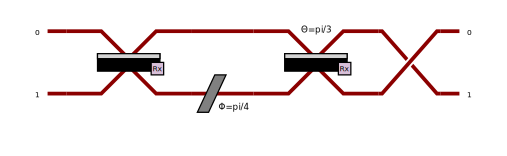

In [13]:
import numpy as np
import perceval as pcvl
from perceval.components import PS, BS, PERM

#Create a circuit with 2 optical modes
circuit = pcvl.Circuit(m=2)
circuit.add(0, BS()) # Add a beam-splitter starting from mode 0
circuit.add(1, PS(phi=np.pi/4)) # Add a phase shifter with phase pi/4 on mode 1
circuit.add(0, BS(theta=np.pi/3)) # Add a beam-splitter with angle pi/3
circuit.add(0, PERM([1,0])) # Add a SWAP

# Display the circuit
pcvl.pdisplay(circuit)

In addition, universal interferometers (Reck or Clements type) can be build automatically

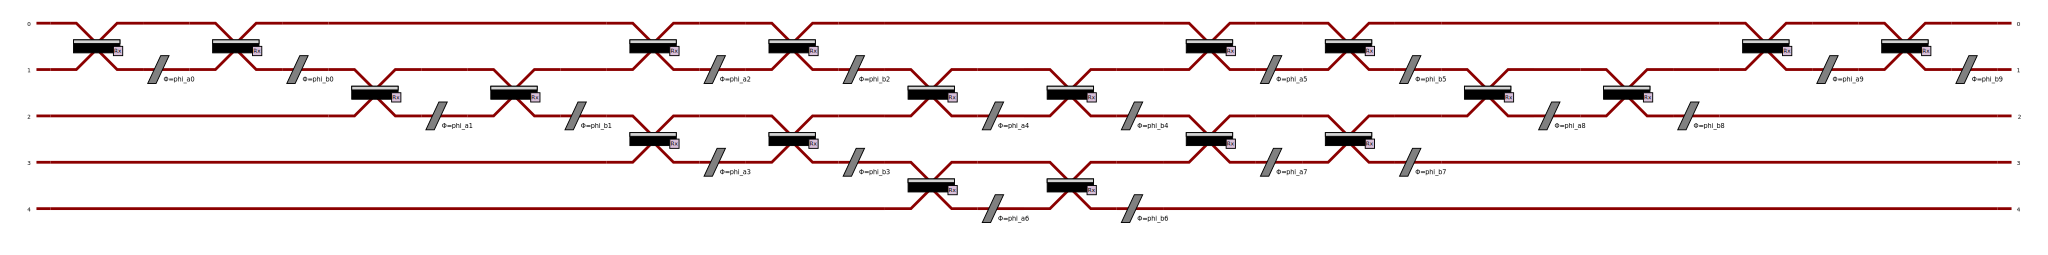

In [14]:
generic_interferometer = pcvl.GenericInterferometer(m=5, # Creates a universal interferometer over 5 modes
                                                    fun_gen=pcvl.catalog['mzi phase last'].generate, # Set the position of the Mach-Zender Interferometers
                                                    shape=pcvl.InterferometerShape.TRIANGLE # Create a Reck interferometer. For the Clement interferometer use pcvl.InterferometerShape.RECTANGLE
                                                   )
pcvl.pdisplay(generic_interferometer)

From a circuit, one can compute the associated unitary as follows:

Unitary associated with the following circuit:
 [[-0.4330127 +0.78656609j  0.07945931+0.4330127j ]
 [ 0.36237244-0.25j       -0.25      +0.86237244j]]


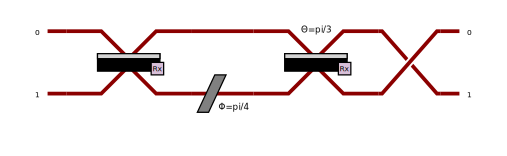

In [15]:
print('Unitary associated with the following circuit:\n', circuit.compute_unitary())
pcvl.pdisplay(circuit)

Moreover, the reverse is also possible. Namely, given a unitary $U$, one can create a circuit implementing $U$. For example, let's consider the Hadamard gate:

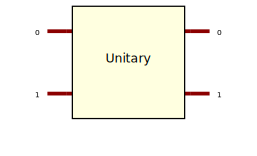

In [16]:
H = 1./np.sqrt(2) * np.array([[1, 1],
                             [1, -1]])
H = pcvl.Matrix(H)

Hadamard = pcvl.Unitary(H)
pcvl.pdisplay(Hadamard)

The unitary can furthermore be decomposed as a generic interferometer, and therefore be expressed in terms of the native phase shifter and beam splitter operations:

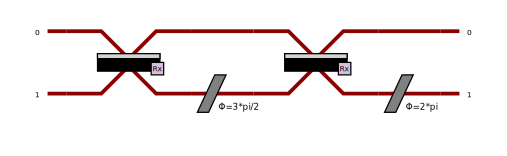

In [17]:
# Define a Mach-Zender interferometer
mzi = pcvl.GenericInterferometer(m=2,
                                 fun_gen=pcvl.catalog['mzi phase last'].generate)

# Decompose the Hadamard gate in terms of phase shifters and beam splitters
Hadamard_circuit = pcvl.Circuit.decomposition(H, mzi)
pcvl.pdisplay(Hadamard_circuit)

### States

Perceval allows the creation of both ```BasicStates``` (without superposition) such as:
$$\left|0, 2, 1, 3\right>$$

There are multiple ways to do so:

In [18]:
# Using a string
state1 = pcvl.BasicState('|0, 2, 1, 3>')

# Using an list (or tuple)
state2 = pcvl.BasicState([0, 2, 1, 3])

# Both representations give the same state
assert state1 == state2

```BasicStates``` can also be combined using the tensor product:

In [19]:
state = pcvl.BasicState([0, 2]) * pcvl.BasicState('|1, 3>')
assert state == state1

or using superposition, such as:

In [20]:
superposition_state = pcvl.BasicState([0, 2, 1, 3]) + pcvl.BasicState([0, 0, 1, 0])
print(superposition_state)

0.707*|0,2,1,3>+0.707*|0,0,1,0>


**Note 1:** The state will be normalised automatically. Therefore, the above state corresponds the following state:
$$\frac{1}{\sqrt{2}}\left|0, 2, 1, 3\right> + \frac{1}{\sqrt{2}}\left|0, 0, 1, 0\right>$$

**Note 2:** The types of superposition and non-superposition states are different:
- ```BasicState``` for non-superposition states
- ```StateVectors``` for more general states

From the state, one can also retrieve the number of photons and the number of modes as follows:

In [21]:
print(f'The state {state} is defined over {state.m} modes and has {state.n} photons.')
print(f'The state {superposition_state} is defined over {superposition_state.m} modes and has number of photons in {superposition_state.n}.')

The state |0,2,1,3> is defined over 4 modes and has 6 photons.
The state 0.707*|0,2,1,3>+0.707*|0,0,1,0> is defined over 4 modes and has number of photons in {1, 6}.


### Computing Probability distributions

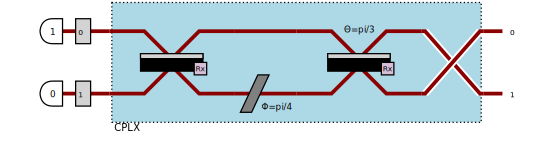

In [22]:
state = pcvl.BasicState('|1, 0>')

processor = pcvl.Processor(backend='SLOS', # Choose a backend. For (strong) simulations, SLOS is recommended
                           m_circuit=circuit # Set the circuit
                          )
# Set the input state 
processor.with_input(state)
# Set the number of photon detected. By setting it to the number of input photons, we remove all the photon loss scenarios
processor.min_detected_photons_filter(1)

# Display the processor the same way we displayed circuits earlier
pcvl.pdisplay(processor, recursive=True)
# NOTE: the argument 'recursive' in the pdisplay function allows us to "open the boxes" 

By default, the ```Processor``` instance will simulate *photon number resolving detectors*; namely, it counts the following states as distinct:
$$\left|1, 0\right> \neq  \left|2, 0\right> \neq \left|3, 0\right>$$

On the other hand, more realistic detectors are *threshold detectors* which either the detect the presence or absence of photons. In other words, the above states are indistinguishable since the signal detected for all of them is:
$$\left|1, 0\right>$$
(1 photon detected in the first mode, no photon detected in the second mode).<br>
In order to simulate this type of detected, we simply pass the following argument to the processor (note that threshold detectors appear when displayed):

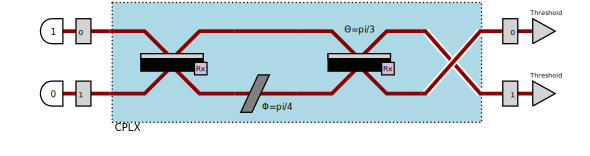

In [23]:
processor.thresholded_output(True)
pcvl.pdisplay(processor, recursive=True)

Using this ```processor``` we can create a ```Sampler``` which can return:
- probabilities;
- or samples.

These are returned as a dictionary where the keys are ```BasicState``` and the values are the associated probabilities/counts.

In [25]:
from perceval.algorithm import Sampler

# Define a number of samples
n_samples = 100

sampler = Sampler(processor)
probability_distribution = sampler.probs()['results']
sample_counts = sampler.sample_count(n_samples)['results']

print('Probability distribution: ', '\n', probability_distribution, end='\n\n')
print(f'Sample counts for a total of {n_samples} samples: ', '\n', sample_counts)

Probability distribution:  
 {
  |1,0>: 0.8061862178478972
  |0,1>: 0.19381378215210274
}

Sample counts for a total of 100 samples:  
 {
  |1,0>: 79
  |0,1>: 21
}


### Recap

Let's recap the steps to create and evaluate a photonic circuit:
1. Build the circuit using the ```Circuit``` class and define the initial state using ```BasicStates```
2. Create a ```Processor``` which combines input states, circuit and detectors
3. Setup a ```Sampler``` which allows us to obtain probabilities and samples

## The Hong Ou Mandel (HOM) effect

We'll now take a look at a few end-to-end examples which demonstrates the power of linear optics. 

### What is the HOM effect?

The Hong Ou Mandel effect describes the interaction of 2 indistinguishable photon through a 50/50 beam-splitter with matrix:
$$\frac{1}{\sqrt{2}}\begin{pmatrix}1 & i \\ i & 1\end{pmatrix}$$

Let's start by defining the circuit and initial state and generate the corresponding the processor

Initial state:  |1,1>
Circuit


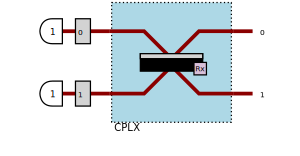

In [26]:
initial_state = pcvl.BasicState([1,1])
print('Initial state: ', initial_state)

HOM_circuit = pcvl.Circuit(2).add(0, BS())

processor = pcvl.Processor(backend='SLOS',
                           m_circuit=HOM_circuit)
processor.with_input(initial_state)
processor.min_detected_photons_filter(2)

print('Circuit')
pcvl.pdisplay(processor, recursive=True)

Now, what do we expect the output to be?

There are 4 possible paths that are possible namely:

Accordingly, there are 3 possible outcomes that we can measure, namely:
- $\left|2, 0\right>$
- $\left|1, 1\right>$
- $\left|0, 2\right>$

Let's now calculate the amplitudes associated with each of these states. <br>
For the 1st photon, we have:
$$a^\dagger_0\mapsto \frac{1}{\sqrt{2}}\cdot a^\dagger_0 + \frac{i}{\sqrt{2}}\cdot a^\dagger_1$$
Similarly, for the second photon, we have:
$$a^\dagger_1\mapsto \frac{i}{\sqrt{2}}\cdot a^\dagger_0 + \frac{1}{\sqrt{2}}\cdot a^\dagger_1$$
So overall, the state $\left|1,1\right> = a^\dagger_0 a^\dagger_1\left|\empty\right>$ is mapped to to:
$$\begin{align*}&\frac{1}{2}\left(a^\dagger_0 + ia^\dagger_1\right)\left(ia^\dagger_0 + a^\dagger_1\right)\left|\empty\right>\\
=&\frac{1}{2}\left(i a^{\dagger 2}_0 + a^\dagger_0a^\dagger_1 - a^\dagger_0a^\dagger_1 + i a^{\dagger 2}_1\right)\left|\empty\right>\\
=& \frac{i}{2}\left(a^{\dagger 2}_0 + a^{\dagger 2}_1\right)\left|\empty\right>\\
=& i \left(\frac{1}{\sqrt{2}}\left|2, 0\right> + \frac{1}{\sqrt{2}}\left|0, 2\right>\right)\end{align*}$$

In other words, the only possible states to measure are: $\left|2, 0\right>, \left|0, 2\right>$. Let's check this

In [27]:
sampler = Sampler(processor)
probability_distribution = sampler.probs()['results'] 

print('Probability distributions:\n', probability_distribution)

Probability distributions:
 {
  |2,0>: 0.5
  |0,2>: 0.5
}


### Exploring noise models

It is possible in ```perceval``` to simulate noisy circuits. <br>
There are many different sources of noise that a real hardware could have. The main ones are:
- **Distinguishability**
- **Photon loss**
- **Multiple emission**

We'll start by looking at distinguishability. If the photons are not exactly the same (i.e. if they are distinguishable), the two amplitudes coresponding to the following paths:
do not entirely cancel each other out. In that case, there is therefore a non-zero probability of measuring the photons in the state $\left|1,1\right>$

In [28]:
# We start by creating a noise model
noise = pcvl.NoiseModel(indistinguishability=0.5)
# Then, we do the same steps as before, but this time including our custom noise model
noisy_processor = pcvl.Processor(backend='SLOS',
                                 m_circuit=HOM_circuit,
                                 noise=noise # Let's add some noise
                                )
noisy_processor.with_input(initial_state)
noisy_processor.min_detected_photons_filter(2)
sampler = Sampler(noisy_processor)
probability_distribution_distinguishable = sampler.probs()['results']

print(probability_distribution_distinguishable)

{
  |2,0>: 0.37500000000000006
  |1,1>: 0.24999999999999994
  |0,2>: 0.37500000000000006
}


Next, we look at photon losses. From sources to detectors, there are many places where photons could be lost or absorbed. This means that the number of photons detected (even with PNR) can be less than the number of incoming photons. The transmittance rate (i.e. the rate at which the photon are transmitted rather than lost), can be defined as follows:

In [29]:
noise = pcvl.NoiseModel(transmittance=0.5)
noisy_processor2 = pcvl.Processor(backend='SLOS',
                                  m_circuit=HOM_circuit,
                                  noise=noise)
noisy_processor2.with_input(initial_state)
noisy_processor2.min_detected_photons_filter(0) # Set the minimum photon detected to be zero so that we can observe photon losses
sampler = Sampler(noisy_processor2)
probability_distribution_photonloss = sampler.probs()['results']

print(probability_distribution_photonloss)

{
  |0,0>: 0.25
  |1,0>: 0.25000000000000006
  |0,1>: 0.25000000000000006
  |2,0>: 0.12500000000000006
  |0,2>: 0.12500000000000006
}


We now look at multiple emissions. <br>
It is also possible that the source would emit more than 1 photon at a time. The consequence is that there might be more photons detected than expected. In general, it is way more probable that the source will produce 2 photons than more than 2 photons. We will therefore only consider the double emission rate:

In [30]:
noise = pcvl.NoiseModel(g2=0.5)
noisy_processor3 = pcvl.Processor(backend='SLOS',
                                  m_circuit=HOM_circuit,
                                  noise=noise)
noisy_processor3.with_input(initial_state)
noisy_processor3.min_detected_photons_filter(2)
sampler = Sampler(noisy_processor3)
probability_distribution_multiple_emission = sampler.probs()['results']
print(probability_distribution_multiple_emission)

{
  |4,0>: 0.125
  |3,1>: 0.25
  |2,2>: 0.25
  |1,3>: 0.25
  |0,4>: 0.125
}


Finally, we will look at a noisy simulation where the noise model is close to the characteristics of our current hardware.

In [31]:
noise = pcvl.NoiseModel(g2=0.014,
                        indistinguishability=0.86,
                        transmittance=0.05)
noisy_processor = pcvl.Processor(backend='SLOS',
                                  m_circuit=HOM_circuit,
                                  noise=noise)
noisy_processor.with_input(initial_state)
noisy_processor.min_detected_photons_filter(0)
sampler = Sampler(noisy_processor)
probability_distribution_realistic = sampler.probs()['results']
print(probability_distribution_realistic)

{
  |0,0>: 0.9018609726112201
  |2,0>: 0.0011785612575342852
  |1,1>: 0.00020864485178421786
  |0,2>: 0.0011785612575342852
  |1,0>: 0.047786630010963595
  |0,1>: 0.047786630010963595
}


### Running circuits on Quandela's hardware

In order to use Quandela's cloud, you first need to create an account here: [https://cloud.quandela.com/](https://cloud.quandela.com/)

Once logged in the interface looks like this:
![Quandela Cloud Dashboard](./imgs/cloud.png)

Tokens can be created from here:
![Quandela Cloud Dashboard](./imgs/token.png)

and then copy-pasted here:

In [181]:
token = 'YOUR_TOKEN'

There are many platforms to run circuits on, including simulators and QPUs. You can see which platforms are available at any time from the *Platforms* tab on the cloud. Here, we will simply use a simulator of the *Ascella* chip.

In [182]:
platform = 'sim:ascella'

Then, instead of creating a standard ```Processor``` instance as before, we'll create a ```RemoteProcessor```

In [183]:
remote_processor = pcvl.RemoteProcessor(name=platform,
                                        token=token)

We can inspect the specs of the of the platform such as the maximum number of modes and photons, or the circuit implemented on the chip (note: that's always a generic interferometer)

Platform constraints:
 {'max_mode_count': 12, 'max_photon_count': 6, 'min_mode_count': 1, 'min_photon_count': 1}


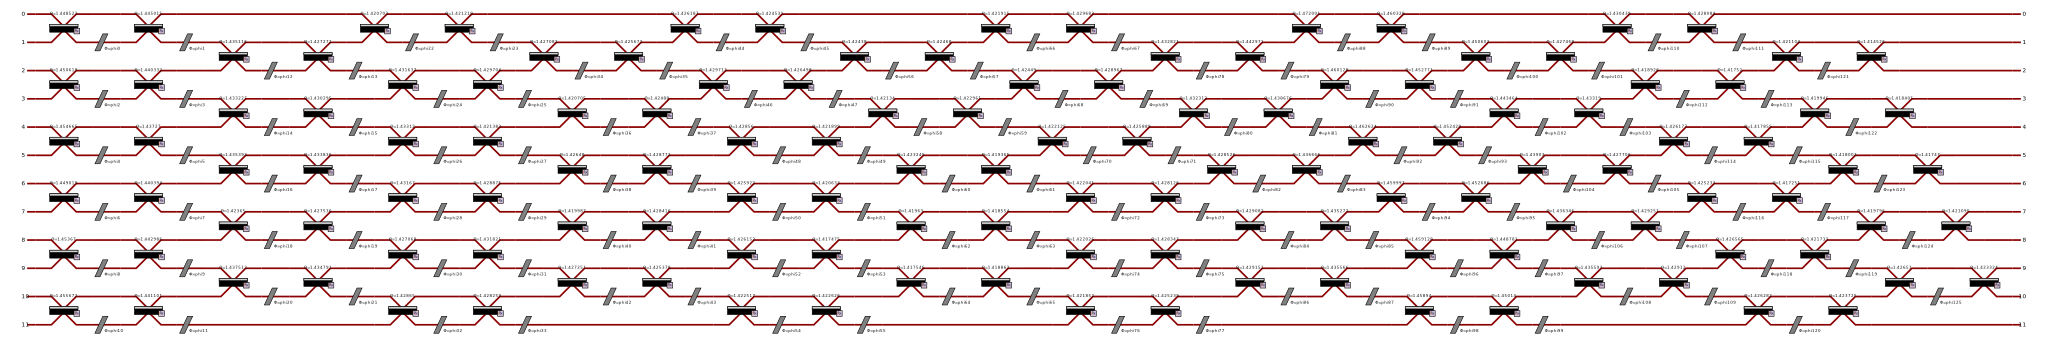

In [185]:
specs = remote_processor.specs

print("Platform constraints:\n", specs["constraints"])

pcvl.pdisplay(specs["specific_circuit"])


Then, we can set the circuit, initial state etc.

In [192]:
remote_processor.set_circuit(HOM_circuit)
remote_processor.with_input(initial_state)
remote_processor.min_detected_photons_filter(1)

The next step is to create a ```Job``` instance

In [193]:
# Set a number of samples
n_samples = 1000

# Define a sampler (same as a local simulation) 
sampler = Sampler(remote_processor,
                                 max_shots_per_call=n_samples)  # You have to set a 'max_shots_per_call' named parameter

sampler.default_job_name = "My sampling job"  # All jobs created by this sampler instance will have this custom name on the cloud

# In order to get the job going on the cloud, you can then run the following command:
remote_job = sampler.sample_count.execute_async(n_samples)

# And here will be the job's id (useful to keep track of the progress on the cloud IDE)
print(f'Job {remote_job.id} created')

Job edcacde6-fdfa-4829-994d-6fdc9ddd43fb created


We can always check the progress of a job using the following commands:

In [196]:
print('Job progress: ', remote_job.status.progress) #Note: the progress is sent back to 0 once it is completed
print('Job completed: ', remote_job.is_complete)

Job progress:  0.0
Job completed:  True


Once completed, the results are obtained as follows:

In [199]:
samples_cloud = remote_job.get_results()['results']
print(samples_cloud)

{
  |0,1>: 484
  |1,0>: 513
  |1,1>: 3
}


## Qubit computations

Let us now see how we can do gate-based quantum computing using linear optics alone.

### Dual rail encoding
We start by defining what is our qubit going to be. Given 2 modes and 1 photon, we define:

$$\left|0\right>_{q} = \left|1, 0\right>_{lo}$$
$$\left|1\right>_{q} = \left|0, 1\right>_{lo}$$

where $\left|\psi\right>_{q}$ denotes a qubit state, while $\left|\psi\right>_{lo}$ denotes a Fock state. I.e.

![Dual rail qubit](./imgs/dual_rail.png)

This is known as the **dual rail encoding**.

In [32]:
q0 = pcvl.BasicState('|1, 0>') # |0>_q
q1 = pcvl.BasicState('|0, 1>') # |1>_q

### Single qubit gates

In order to apply a single qubit gate $U$, all we have to do is to apply an interferometer with matrix $U$ onto the two optical modes. *(can you see why?)* <br>
All single qubit gate are easy to achieve in linear optics (and dual rail encoding) as they can be expressed as a Mach-Zender Interferometer (MZI).

As an example, let's take back our circuit we obtained for the Hadamard gate:

In [33]:
#Define a processor
processor = pcvl.Processor(backend='SLOS',
                           m_circuit=Hadamard)
processor.min_detected_photons_filter(1)

# Calculate the probability distribution for H|0>
processor.with_input(q0)
print('Probabilities for H|0>:\n', processor.probs()['results'])
# NOTE: for a processor with SLOS backend, the probabilities can be calculated without having to go through a Sampler 

# Calculate the probability distribution for H|1>
processor.with_input(q1)
print('Probabilities for H|1>:\n', processor.probs()['results'])

Probabilities for H|0>:
 {
  |1,0>: 0.5
  |0,1>: 0.5
}
Probabilities for H|1>:
 {
  |1,0>: 0.5
  |0,1>: 0.5
}


Other standard single-qubit gates such as the $X$ ans $Z$ gates are implemented as follows *(check that it works!)*:

In [34]:
Z = pcvl.Circuit(2).add(1, PS(phi=np.pi))
X = pcvl.Circuit(2).add(0, PERM([1, 0]))

### The Ralph CNOT

In order to achieve universal quantum computation, we also need to have an entangling gate such as the CNOT gate. Using linear optics only, this is done using post-selection.

We'll here describe a standard way of implementing the CNOT gate using linear optics that was first described here: [1].

This implementation of the CNOT is directly pre-coded in ```Perceval```. Let's load it.

[1] T. C. Ralph, N. K. Langford, T. B. Bell, and A. G. White. Linear optical controlled-NOT gate in the coincidence basis. Physical Review A, 65(6):062324, June 2002. Publisher: American Physical Society.

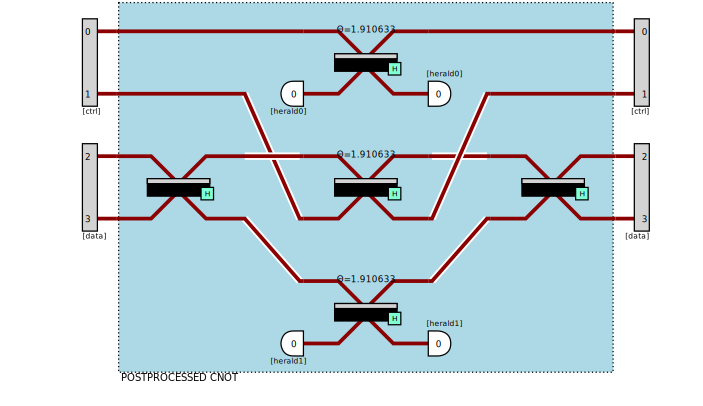

In [59]:
cnot = pcvl.catalog['postprocessed cnot'].build_processor()
pcvl.pdisplay(cnot, recursive=True)

As we can see, the circuit requires:
- **Ancilla modes**, which means that each CNOT requires 2 additional modes
- **Heralding**, which means that the CNOT gate will be probabilistic

Let us now check the behaviour of the CNOT gate, as well as the success probability we can achieve (i.e. how often is the heralding signal correct).

In [69]:
for control in [q0, q1]:
    for target in [q0, q1]:
        initial_state = control * target
        cnot.with_input(initial_state)
        results = cnot.probs()
        print('Initial state: ', initial_state)
        print('Probability distribution:\n', results['results'])
        print('Probability of success: ', results['logical_perf'], end='\n-----------------------------------------------------\n')
        # Probability of success of 1/9

Initial state:  |1,0,1,0>
Probability distribution:
 {
  |1,0,1,0>: 1.0
}
Probability of success:  0.11111111111111113
-----------------------------------------------------
Initial state:  |1,0,0,1>
Probability distribution:
 {
  |1,0,0,1>: 1.0
}
Probability of success:  0.11111111111111113
-----------------------------------------------------
Initial state:  |0,1,1,0>
Probability distribution:
 {
  |0,1,0,1>: 1.0
}
Probability of success:  0.11111111111111117
-----------------------------------------------------
Initial state:  |0,1,0,1>
Probability distribution:
 {
  |0,1,1,0>: 1.0
}
Probability of success:  0.11111111111111113
-----------------------------------------------------


### Qubit computations on qudits

Since all of the entangling gates are probabilistic, a naive compilation approach will decrease the success probability of the circuit as the depth of the circuit increases. Thankfully, it is also possible to trade extra optical modes for a better success probability.

To see how it works, let's look again at the example of the CNOT gate. If we we take the initial state a single qudit with $d=4$ with the encoding:
$$\left|00\right>_{q} = \left|1, 0, 0, 0\right>_{lo}$$
$$\left|01\right>_{q} = \left|0, 1, 0, 0\right>_{lo}$$
$$\left|10\right>_{q} = \left|0, 0, 1, 0\right>_{lo}$$
$$\left|11\right>_{q} = \left|0, 0, 0, 1\right>_{lo}$$
then, the CNOT gate simply becomes:

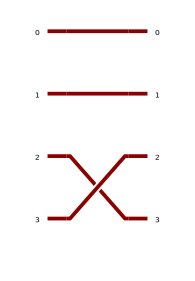

In [35]:
qudit_CNOT = pcvl.Circuit(4).add(2, PERM([1,0]))
pcvl.pdisplay(qudit_CNOT)

One can indeed check that:
$$\left|00\right>_{q} \mapsto \left|00\right>_{q}$$
$$\left|01\right>_{q} \mapsto \left|01\right>_{q}$$
$$\left|10\right>_{q} \mapsto \left|11\right>_{q}$$
$$\left|11\right>_{q} \mapsto \left|10\right>_{q}$$
with probability 1 ! <br>
Using this trick on some subsystems allows us to obtain better success probabilities. See [2] for more details.

[2] L. Lysaght, T. Goubault, P. Sinnott, S. Mansfield, P-E. Emeriau, “Quantum circuit compression using qubit logic on qudits,” https://arxiv.org/abs/2411.03878v1 (2024).

## Photonic-native variational circuits

In the next case study, we look at variational photonic circuits, and how they can be used to *learn from data*. In particular, since we are not constrained to the qubit picture anymore, we will look at algorithms with can be implemented deterministically and natively on our photonic devices.

Our aim here will be to sort points on $\mathbb{R}^2$ between 2 different classes (that we will denote by $0$ and $1$). Let's have a look at what these classes look like!

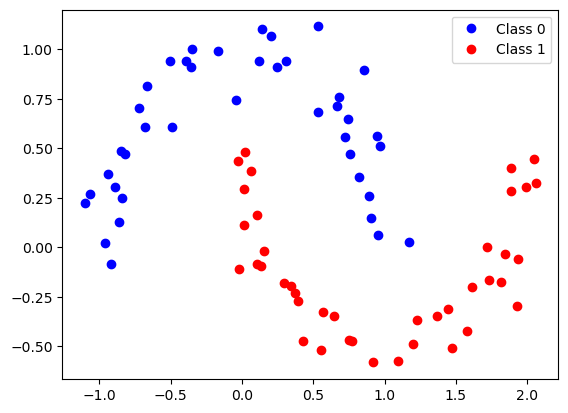

In [52]:
import matplotlib.pyplot as plt

#Load the dataset
dataset = np.genfromtxt('./trainset.csv', delimiter=',')
trainset = dataset[:, :2] # The first 2 columns stores the data
labels = dataset[:, 2] # The last column stores the label

plt.plot(trainset[labels==0][:,0], trainset[labels==0][:,1], 'bo', label='Class 0')
plt.plot(trainset[labels==1][:,0], trainset[labels==1][:,1], 'ro', label='Class 1')
plt.legend()
plt.show()

### Parameters

Before going deep in the training process, we'll see how to create and use parameters in ```perceval```. 

First we see that we can create a ```Parameter``` instance, and feed it as the phase of a component

My parameter:  Parameter(name='my_phase', value=None)
Parametric Matrix:  Matrix([[exp(I*my_phase)]])


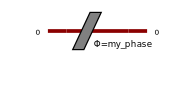

In [37]:
my_parameter = pcvl.Parameter(name='my_phase')
print('My parameter: ', my_parameter) # Note that there are no values associated with the parameter yet

# Create a phase shifter dependent on this parameter
parametric_phase_shifter = pcvl.PS(phi=my_parameter)
print('Parametric Matrix: ', parametric_phase_shifter.compute_unitary(use_symbolic=True))
pcvl.pdisplay(parametric_phase_shifter)

Then, if we need to assign a value to this parameter, this can be done as follows:

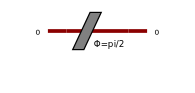

In [39]:
my_parameter.set_value(np.pi/2)
pcvl.pdisplay(parametric_phase_shifter)
# The phase of the phase shifter has been set to pi/2 ! 

Now, we define an *ansatz*, i.e. the basic structure of a quantum circuit which contains tunable parameters. 

In particular, we will use the ansatz from [3] which consists on alternating:
- Random unitaries $W(\theta)$ (independent of the data) and
- Phase shifters composed in parallel, where the phases directly depend on the values of the input data (i.e. the coordinates on the $\mathbb{R}^2$ plane).

[3] Gan, B. Y., Leykam, D., & Angelakis, D. G. (2022). Fock state-enhanced expressivity of quantum machine learning models. EPJ Quantum Technology, 9(1), 16.

In [ ]:
from perceval import Parameter
import re

def mzi(param1, param2):
    """
    Defines a Mach Zender Interferometer in terms of parameters
    """
    circuit = pcvl.Circuit(2)
    circuit.add(0, BS())
    circuit.add(1, PS(param1))
    circuit.add(0, BS())
    circuit.add(1, PS(param2))
    return circuit

def generate_circuit(n_layers=1):
    circuit = pcvl.Circuit(m=3)
    circuit.add(0, 
                pcvl.GenericInterferometer(m=3,
                                           fun_gen=lambda idx: mzi(Parameter(name=f'layer0_phi1_{idx}'),
                                                                   Parameter(name=f'layer0_phi2_{idx}'))
                                          )
               )
    for layer in range(n_layers):
        for idx in range(2):
            circuit.add(idx, PS(phi=Parameter(f'layer{layer}_x_{idx}')))
        circuit.add(0,
                    pcvl.GenericInterferometer(m=3,
                                               fun_gen=lambda idx: mzi(Parameter(name=f'layer{layer+1}_phi1_{idx}'),
                                                                       Parameter(name=f'layer{layer+1}_phi2_{idx}')))
                   )
    return circuit

Let's see what the circuits look like:

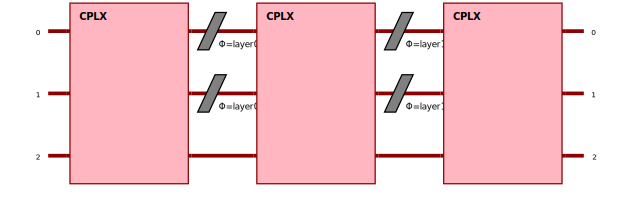

In [42]:
ansatz = generate_circuit(n_layers=2)
pcvl.pdisplay(ansatz)

In addition, all of the parameters of the ansatz (including the interferometer phases, and the phases of the phase shifters used to encode the data) can be obtained as follows:

In [45]:
print('These are all of the parameters of my circuit:')
for p in ansatz.get_parameters():
    print(p)
# Note again that the phases are not set yet 

These are all of the parameters of my circuit:
Parameter(name='layer0_phi1_0', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer0_phi2_0', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer0_phi1_1', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer0_phi2_1', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer0_phi1_2', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer0_phi2_2', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer0_x_0', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer0_x_1', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer1_phi1_0', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer1_phi2_0', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer1_phi1_1', value=None, min_v=0.0, max_v=6.283185307179586)
Parameter(name='layer1_phi2_1', value=None, min_v=0.0, max_v=6.283185307179586)

Then, we'll need to define how the data is transformed by our ansatz.

In [50]:
def data_to_phase(x):
    """
    This is a function that takes in real data, and rescales it to the interval (0, pi)
    """
    sigmoid = 1./(1+np.exp(-x))
    return np.pi * sigmoid

def compute_output(x, theta, circuit):
    """
    This is the main function which defines what to do with the data
    """
    
    # We then set all of the phases
    theta_index = 0 # trainable phases count
    for param in circuit.get_parameters():
        is_data_param = re.match("\w*_x_\w*", param.name)
        if is_data_param:
            # Set the value of the phase in the corresponding phase shifter
            data_index = int(param.name[-1])
            param.set_value(data_to_phase(x[data_index]))
        else:
            # If the parameter is a trainable parameter, we set it to the next parameter in the list
            param.set_value(theta[theta_index])
            theta_index += 1
    
    # Set up the processor
    processor = pcvl.Processor('SLOS', circuit)
    processor.with_input(pcvl.BasicState([1, 0, 1])) # Take |1, 0, 1> as the initial state (arbitrary)
    probs = processor.probs()['results']

    # Coarse-grain the probability distribution s.t. there are only 2 possible outcomes (corresponding the the classes 0 or 1)
    ## Define the states associated with the class 1
    class1_states = [pcvl.BasicState([2, 0, 0]), pcvl.BasicState([1, 1, 0]), pcvl.BasicState([0, 2, 0])]
    ## Calculate the probability associated with the class 1
    prob_class1 = sum([probs[state] for state in class1_states])

    return prob_class1

We are now ready to train our model!

To do so, we define a *loss function* (also known as *cost function*). This function characterises how good or bad our model is at classifying the data. Then, we define an *optimizer*, which is an algorithm that will tune the (trainable) parameters of the ansatz to **minimize the loss function**.

Here, we will use a standard loss function, namely the *binary cross entropy* (BCE), defined as follows:
$$BCE(P, L) = \frac{-1}{N}\sum_x L(x)~logP(x=1) + (1-L(x))~log P(x=0)$$
where:
- $P$ is the probability distribution obtain from the model that estimate how likely a datapoint is in the class 0 or 1;
- $L$ is the function which associates a label to a datapoint; 
- $x$ is a datapoint;
- $N$ is the total number of datapoints.

As for the optimizer, we will here use predefined optimizers in ```scipy```, more specifically, we'll use the *COBYQA* algorithm (which has been shown to give good results on photonic circuits in general).

In [ ]:
from scipy.optimize import minimize

def loss(trainset, labels, params, circuit):
    """
    Defines the binary cross entropy loss
    """
    outputs = np.array([compute_output(x, params, circuit) for x in trainset])
    w_log1 = np.log(outputs) * labels
    w_log0 = np.log(1 - outputs) * (1-labels)
    return -np.mean(w_log0+w_log1)

def train(trainset, labels, n_layer):
    """
    Full training function
    """
    # Generate the ansatz
    ansatz = generate_circuit(n_layer)
    n_param_per_layer = 6 # Number of phases per layer

    # Randomly initialise the parameters
    init_param = 2*np.pi*np.random.rand((n_layer+1)*n_param_per_layer)

    # Minimize the loss function
    opt = minimize(lambda p: loss(trainset, labels, p, ansatz),
                   x0=init_param,
                   method='COBYQA')
    print('Result of the optimization:\n', opt)
    return ansatz, opt.x


n_layer = 1
circuit, params = train(trainset, labels, n_layer) # Should take about 1 min to complete

Result of the optimization:
  message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: 0.3644305007421325
       x: [ 1.020e+00  3.891e+00  3.142e+00  5.847e+00  3.840e+00
            1.097e+00  1.571e+00  5.707e+00 -6.075e-07  4.289e+00
            2.146e+00 -5.878e-01]
     nit: 186
   maxcv: 0.0
    nfev: 305


Let's now evaluate our model, first, on the train set that we previously used in the training process, then on a *validation set* (or *test set*) which the model has not seen during training. The purpose of the validation set is to evaluate how much the model can generalise what it has learnt to new datapoints

Accuracy (train set):  0.8
Accuracy (test set):  0.85


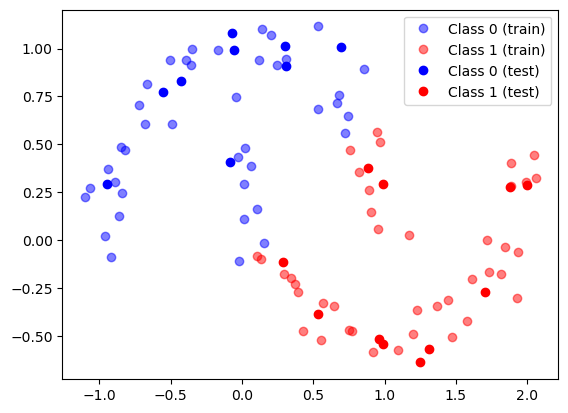

In [51]:
#Load the test dataset
dataset = np.genfromtxt('./testset.csv', delimiter=',')
testset = dataset[:, :2]
test_labels = dataset[:, 2]

# Calculate the predictions on both sets (the model will predict the class 1 whenever the probability of being in the classe 1 is > 0.5)
predictions_test = np.array([int(compute_output(x, params, circuit=circuit)>0.5) for x in testset])
predictions_train = np.array([int(compute_output(x, params, circuit=circuit)>0.5) for x in trainset])

# Calculate the accuracy of the model
print('Accuracy (train set): ', np.sum(predictions_train==labels)/len(predictions_train))
print('Accuracy (test set): ', np.sum(predictions_test==test_labels)/len(predictions_test))

# Plot the predictions
plt.plot(trainset[predictions_train==0][:,0], trainset[predictions_train==0][:,1], 'bo', label='Class 0 (train)', alpha=0.5)
plt.plot(trainset[predictions_train==1][:,0], trainset[predictions_train==1][:,1], 'ro', label='Class 1 (train)', alpha=0.5)
plt.plot(testset[predictions_test==0][:,0], testset[predictions_test==0][:,1], 'bo', label='Class 0 (test)')
plt.plot(testset[predictions_test==1][:,0], testset[predictions_test==1][:,1], 'ro', label='Class 1 (test)')
plt.legend()
plt.show()

In addition, let's have a look at a (pre-trained) model containing 5 layers (note if you want to train it yourself, it takes quite a while)

Accuracy (train set):  0.925
Accuracy (test set):  0.95


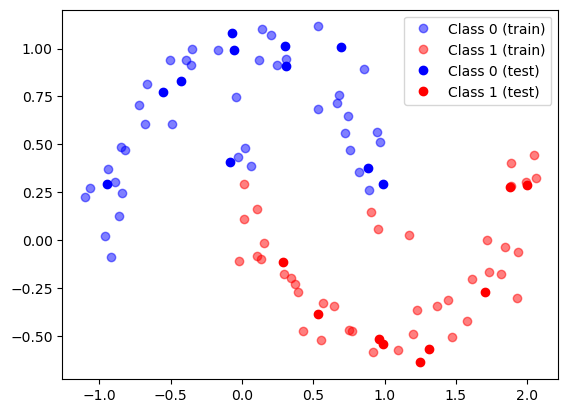

In [55]:
large_ansatz = generate_circuit(n_layers=5)
optimized_params = np.genfromtxt('./optimized_params.csv', delimiter=',')

# Calculate the predictions
predictions_test = np.array([int(compute_output(x, optimized_params, circuit=large_ansatz)>0.5) for x in testset])
predictions_train = np.array([int(compute_output(x, optimized_params, circuit=large_ansatz)>0.5) for x in trainset])

# Calculate the accuracy
print('Accuracy (train set): ', np.sum(predictions_train==labels)/len(predictions_train))
print('Accuracy (test set): ', np.sum(predictions_test==test_labels)/len(predictions_test))

# Plot the predictions
plt.plot(trainset[predictions_train==0][:,0], trainset[predictions_train==0][:,1], 'bo', label='Class 0 (train)', alpha=0.5)
plt.plot(trainset[predictions_train==1][:,0], trainset[predictions_train==1][:,1], 'ro', label='Class 1 (train)', alpha=0.5)
plt.plot(testset[predictions_test==0][:,0], testset[predictions_test==0][:,1], 'bo', label='Class 0 (test)')
plt.plot(testset[predictions_test==1][:,0], testset[predictions_test==1][:,1], 'ro', label='Class 1 (test)')
plt.legend()
plt.show()

## Advanced features

In this last section, we'll explore some other types of components that are currently being developped by the hardware team (but are not yet ready to be implemented experimentally).

### Spin components

On top of the optical mode degree of freedom, a photon can also have a *spin*. The polarization of a photon can be declared in ```perceval``` using the ```P:``` annotation. For example, the following state will be prepared with a photon in the 1st mode, which horizontal polarization

In [71]:
horizontal = pcvl.BasicState('|{P:H}, 0>')
print(f'{horizontal} is polarized: {horizontal.has_polarization}')

|{P:H},0> is polarized: True


Many polarization configurations are pre-defined in ```perceval```, namely:

| Code | Jones vector |
| -------- | ------- |
| ``H`` | $\begin{pmatrix}1\\0\end{pmatrix}$ |
| ``V`` | $\begin{pmatrix}0\\1\end{pmatrix}$ |
| ``D`` | $\frac{1}{\sqrt 2}\begin{pmatrix}1\\1\end{pmatrix}$ |
| ``A`` | $\frac{1}{\sqrt 2}\begin{pmatrix}1\\-1\end{pmatrix}$ |
| ``L`` | $\frac{1}{\sqrt 2}\begin{pmatrix}1\\i\end{pmatrix}$ |
| ``R`` | $\frac{1}{\sqrt 2}\begin{pmatrix}1\\-i\end{pmatrix}$ |

The polarization of a photon can also be manipulated using a **polarizing rotator** ``PR(delta)`` with associated matrix: $\begin{pmatrix}\cos{\left(\delta \right)} & \sin{\left(\delta \right)}\\- \sin{\left(\delta \right)} & \cos{\left(\delta \right)}\end{pmatrix}$, or by a **wave-plate** ``WP(delta, xi)`` with matrix: $\begin{pmatrix}\left[\begin{matrix}i \sin{\left(\delta \right)} \cos{\left(2 \xi \right)} + \cos{\left(\delta \right)} & i \sin{\left(\delta \right)} \sin{\left(2 \xi \right)}\\i \sin{\left(\delta \right)} \sin{\left(2 \xi \right)} & - i \sin{\left(\delta \right)} \cos{\left(2 \xi \right)} + \cos{\left(\delta \right)}\end{matrix}\right]\end{pmatrix}$.

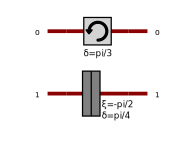

In [78]:
#Define a circuit
polarization_circuit = pcvl.Circuit(m=2).add(0, pcvl.PR(delta=np.pi/3)).add(1, pcvl.WP(delta=np.pi/4, xsi=3*np.pi/2))
pcvl.pdisplay(polarization_circuit)

#### From polarization to rail encoding (and back)

In is possible to have a qubit encoded in the polarization of the photon. This state can be convert to a dual-rail encoded qubit using a **polarizing beam-splitter**. More specifically, a polarxing beam-splitter will make the translation between the following states:

$$\begin{align*}\left|V\right> &\rightarrow \left|1, 0\right>\\
\left|H\right> &\rightarrow \left|0, 1\right>
\end{align*}$$

**Note:** the polarizing beam-splitter also converts dual-rail encoding back to a polarization encoding

Probability distribution:
 {
  |0,1>: 1.0
}


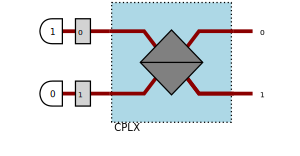

In [85]:
polarization_2_rail = pcvl.Circuit(2).add(0, pcvl.PBS())

processor = pcvl.Processor(backend='SLOS',
                           m_circuit=polarization_2_rail)
processor.with_polarized_input(horizontal)
output = processor.probs()['results']

print('Probability distribution:\n', output)
pcvl.pdisplay(processor, recursive=True)

Now, let's combine a polarization rotator with a polarizing rotator:

Probability distribution:
 {
  |1,0>: 0.5
  |0,1>: 0.5
}


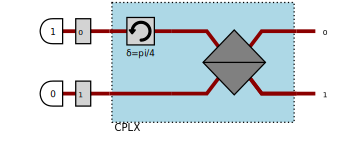

In [88]:
circuit = pcvl.Circuit(2).add(0, pcvl.PR(delta=np.pi/4)).add(0, pcvl.PBS())

processor = pcvl.Processor(backend='SLOS',
                           m_circuit=circuit)
processor.with_polarized_input(horizontal)
output = processor.probs()['results']

print('Probability distribution:\n', output)
pcvl.pdisplay(processor, recursive=True)

## Adaptative measurements

It is also possible to simulate **adaptative measurements**. 

Since these types of operations are no longer unitary, we'll need to define a the 'circuit' as a ``Processor`` instance. Let's see how we can define a deterministic CNOT (where the control qubit is discarded).

First, we define a ``Processor`` over 4 modes (recall that we need 2 modes per qubit)

In [98]:
processor = pcvl.Processor("SLOS", 4)
processor.min_detected_photons_filter(2)

We are going start with initial (qubit) state $\left|0,0\right>$

In [99]:
processor.with_input(pcvl.BasicState([1, 0, 1, 0]))

Next, we apply a Hadamard gate on the first qubit. We will then be in the state $\left|+,0\right>$

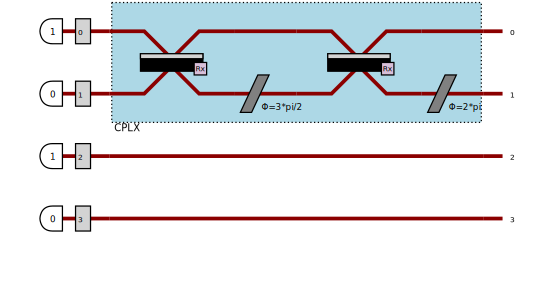

In [100]:
processor.add(0, Hadamard_circuit) # See above for the definition
pcvl.pdisplay(processor, recursive=True)

Here is where we are going to apply an adaptative measurement. The protocol will be as follows:
1. We measure the control (1st) qubit 
2. If the measured qubit is in the state $\left|0\right>$, we do nothing; if we measure $\left|1\right>$, we apply an $X$ gate on the target qubit

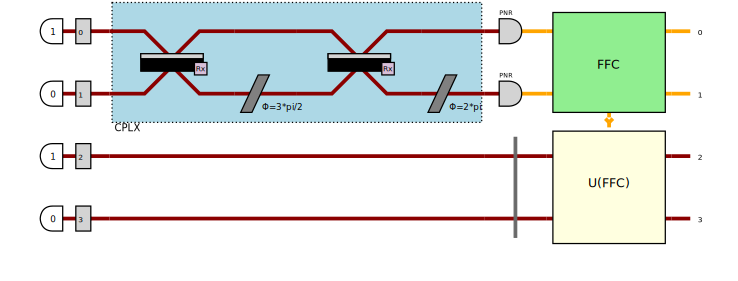

In [101]:
#First, we create a FeedForward configurator
ff_cnot = pcvl.FFCircuitProvider(m=2, # Number of qubits to measure
                                 offset=0, # Where the controled circuit will be applied; by default on the next modes
                                 default_circuit=pcvl.Circuit(2) # Default circuit; here this is the identity
                                )
ff_cnot.add_configuration([0, 1], X)  # If we measure |1>, we apply an X gate on the target qubit

 
# Next, we can add the adaptative measurement to the rest of the circuit
# Step 1: add all of the detectors (NOTE: this has to be done manually)
processor.add(0, pcvl.Detector.pnr()) # Add a PNR detector on the first mode
processor.add(1, pcvl.Detector.pnr()) # Add a PNR detector on the second mode
# Step 2: add the feed-forward configurator
processor.add(0, ff_cnot)
 
pcvl.pdisplay(processor, recursive=True)

Now, all we need to do is to verify that the circuit gives us the correct probability distribution, namely:

$$\begin{align*}
P\left[\left|0,0\right>_q = \left|1,0,1,0\right>_{lo}\right] =& 1/2\\
P\left[\left|1,1\right>_q = \left|0,1,0,1\right>_{lo}\right] =& 1/2
\end{align*}$$

In [102]:
probability_distribution = processor.probs()["results"]
print('Probability distribution:\n', probability_distribution)

Probability distribution:
 {
  |1,0,1,0>: 0.5000000024345003
  |0,1,0,1>: 0.49999999756549973
}


## Other resources

If you want to learn more, we have a few resources available online, including:

| Resource | Link |
| -------- | ------- |
| **Perceval documentation** | https://perceval.quandela.net/docs/ |
| **Training Centre** (NEW!) | https://training.quandela.com/ (lots of courses on different topics) |
| **Quandela Cloud** | https://cloud.quandela.com/  |
| **GitHub repository** | https://github.com/Quandela/Perceval (contribute to ```perceval```!)  |